In [232]:
import pandas as pd
import pdb
from pathlib import Path
from fastai.vision import *
from fastai.vision.gan import *
from sklearn.decomposition import PCA
from pathlib import Path
path = Path("UCRArchive_2018/InsectWingbeatSound")

In [233]:
list(path.iterdir())

[WindowsPath('UCRArchive_2018/InsectWingbeatSound/desktop.ini'),
 WindowsPath('UCRArchive_2018/InsectWingbeatSound/InsectWingbeatSound_TEST.tsv'),
 WindowsPath('UCRArchive_2018/InsectWingbeatSound/InsectWingbeatSound_TRAIN.tsv'),
 WindowsPath('UCRArchive_2018/InsectWingbeatSound/README.md')]

In [311]:
trainDF = pd.read_csv(path/"InsectWingbeatSound_TRAIN.tsv",sep="\t",header=None)
valDF = pd.read_csv(path/"InsectWingbeatSound_TEST.tsv",sep="\t",header=None)
print(trainDF.shape,valDF.shape)

(220, 257) (1980, 257)


In [235]:
trainDS = torch.utils.data.TensorDataset(torch.tensor(trainDF.iloc[:,1:].values,dtype=torch.float),torch.tensor(trainDF.iloc[:,0].values,dtype=torch.long))
valDS = torch.utils.data.TensorDataset(torch.tensor(valDF.iloc[:,1:].values,dtype=torch.float),torch.tensor(valDF.iloc[:,0].values,dtype=torch.long))
trainDS.items, valDS.items = [1,2,3],[1,2,3]
numClasses = len(trainDF.iloc[:,0].unique())
seqLen = trainDF.shape[1]-1
dataClassifier = DataBunch.create(trainDS,valDS,num_workers=0)

In [236]:
tT = torch.tensor(trainDF.iloc[:,1:].values,dtype=torch.float)
vT = torch.tensor(valDF.iloc[:,1:].values,dtype=torch.float)
combT = torch.cat([tT,vT])
trainDS = torch.utils.data.TensorDataset(combT,combT)
valDS = torch.utils.data.TensorDataset(vT,vT)
trainDS.items, valDS.items = [1,2,3],[1,2,3]
dataAE = DataBunch.create(trainDS,valDS,num_workers=0)

In [312]:
class TSAE(torch.nn.Module):
    def __init__(self,seqLen):
        super().__init__()
        self.lin1 = torch.nn.Linear(seqLen,20)
        self.lin2 = torch.nn.Linear(20,300)
        self.out = torch.nn.Linear(300,seqLen)
        
    def forward(self,ts):
        ts = torch.relu(self.lin1(ts))
        ts = torch.relu(self.lin2(ts))
        return self.out(ts)

In [337]:
class TSClassifier(torch.nn.Module):
    def __init__(self,seqLen,numClasses):
        super().__init__()
        self.lin1 = torch.nn.Linear(seqLen,20)
        self.lin2 = torch.nn.Linear(20,300)
        self.out = torch.nn.Linear(300,numClasses)
        
    def forward(self,ts):
        ts = torch.relu(self.lin1(ts))
        ts = torch.relu(self.lin2(ts))
        return self.out(ts)

In [313]:
learnAE = Learner(dataAE,TSAE(seqLen),loss_func=torch.nn.functional.mse_loss)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


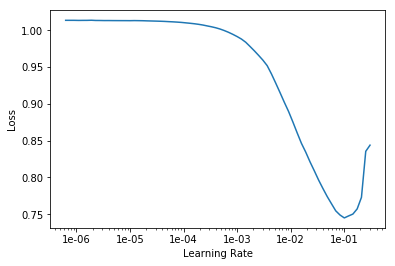

In [314]:
learnAE.lr_find()
learnAE.recorder.plot()

In [317]:
learnAE.fit_one_cycle(20,1e-2)

epoch,train_loss,valid_loss
1,0.016984,0.017022
2,0.017043,0.017039
3,0.017292,0.017284
4,0.017573,0.017615
5,0.017959,0.017808
6,0.018122,0.017781
7,0.018204,0.017527
8,0.018112,0.017167
9,0.017912,0.017028
10,0.017625,0.016727


In [358]:
learnClassifier = Learner(dataClassifier,TSClassifier(seqLen,numClasses),loss_func=torch.nn.functional.cross_entropy,metrics=[accuracy])
learnClassifier.split(split_model_idx(learnClassifier.model,idxs=[0,1]))

In [359]:
learnClassifier.layer_groups

[Sequential(
   (0): Linear(in_features=256, out_features=20, bias=True)
 ), Sequential(
   (0): Linear(in_features=276, out_features=300, bias=True)
   (1): Linear(in_features=300, out_features=11, bias=True)
 )]

In [360]:
learnClassifier.model.lin1.load_state_dict(learnAE.model.lin1.state_dict())
#learnClassifier.model.lin2.load_state_dict(learnAE.model.lin2.state_dict())

In [361]:
x,y = next(iter(dataClassifier.train_dl))
learnClassifier.model(x).size()

torch.Size([64, 11])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


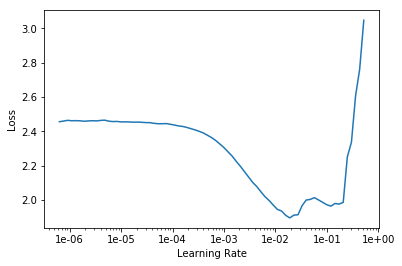

In [364]:
learnClassifier.lr_find()
learnClassifier.recorder.plot()

In [363]:
learnClassifier.freeze_to(1)

In [366]:
learnClassifier.fit_one_cycle(20,1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.587320,1.421545,0.555050
2,0.579012,1.419781,0.553535
3,0.569594,1.416793,0.552525
4,0.573952,1.417866,0.554040
5,0.560894,1.428700,0.553030
6,0.557511,1.437948,0.547980
7,0.551102,1.435142,0.546970
8,0.536698,1.445600,0.548485
9,0.525684,1.449324,0.547980
10,0.527156,1.456567,0.551010


In [367]:
learnClassifier.unfreeze()

In [368]:
learnClassifier.fit_one_cycle(10,[1e-4,1e-3])

epoch,train_loss,valid_loss,accuracy
1,0.496237,1.467680,0.547980
2,0.503418,1.476932,0.546465
3,0.491489,1.485289,0.547980
4,0.498836,1.493103,0.552525
5,0.496315,1.510463,0.551010
6,0.499337,1.529063,0.542424
7,0.483684,1.531644,0.536869
8,0.479995,1.534954,0.539899
9,0.476414,1.531228,0.540404
10,0.481152,1.533611,0.540909


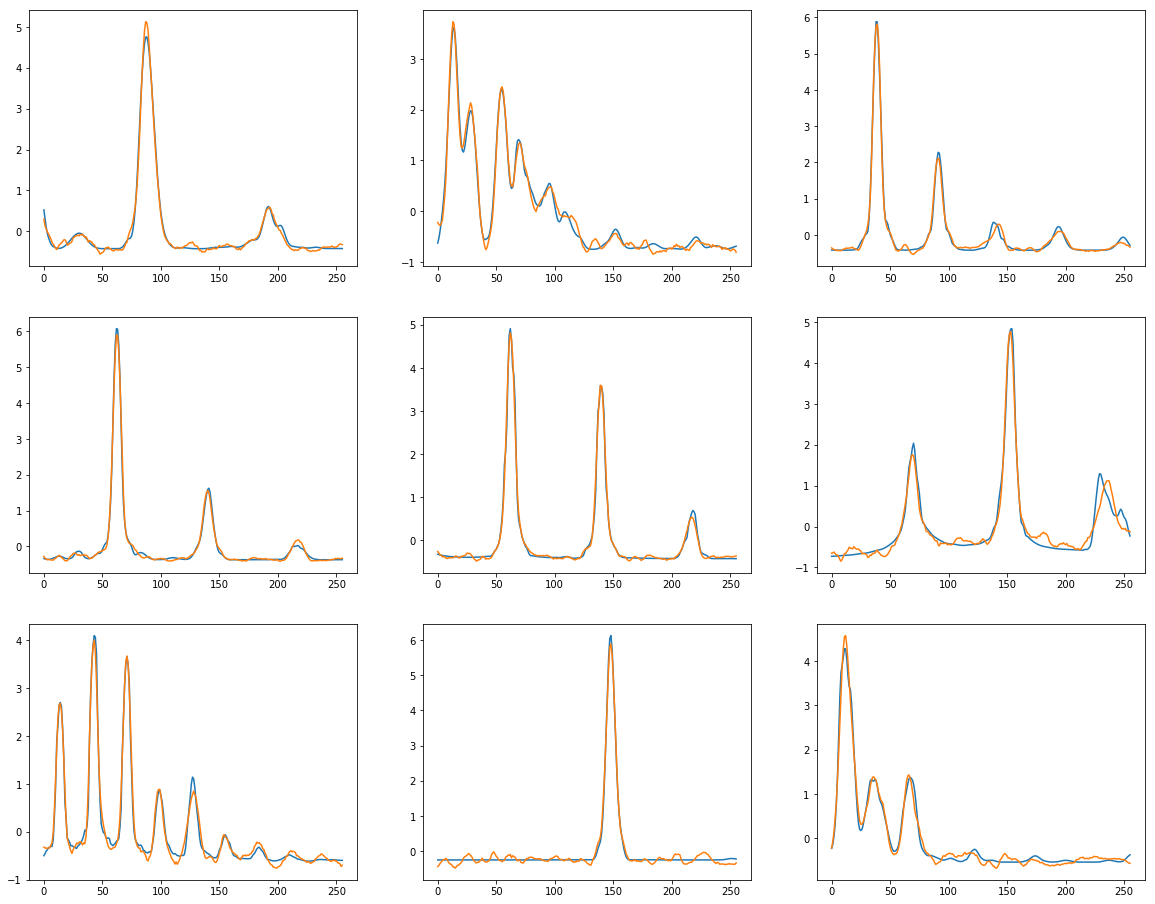

In [357]:
x,y = next(iter(dataAE.train_dl))
learnAE.model.eval()
preds = learnAE.model(x)
_,axes = plt.subplots(3,3,figsize=(20,16))
for ax, ts, p, in zip(axes.flatten(),x,preds):
    ax.plot(ts)
    ax.plot(p)
    